## Minst Data Set

### Pytouch CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# 模型加载选择GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

cpu
0


In [3]:
# 准备训练数据集
train_data = FashionMNIST(
    root="./FashionMNIST",            # 数据的路径
    train=True,                       # 只使用训练数据集
    transform=transforms.ToTensor(),  # 用于对载入的图片数据进行类型转换，将之前构成 PIL 图片的数据转换成 Tensor 数据类型的变量，让 PyTorch 能够对其进行计算和处理。
    download=True
)

# 准备测试数据集
test_data = FashionMNIST(
    root="./FashionMNIST",            # 数据的路径
    train=False,                      # 只使用训练数据集
    download=True
)

# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,              # 使用的数据集
    batch_size=64,                   # 批处理样本大小
    shuffle=False,                   # 每次迭代前不打乱数据
    num_workers=2,                 # 使用两个进程
)

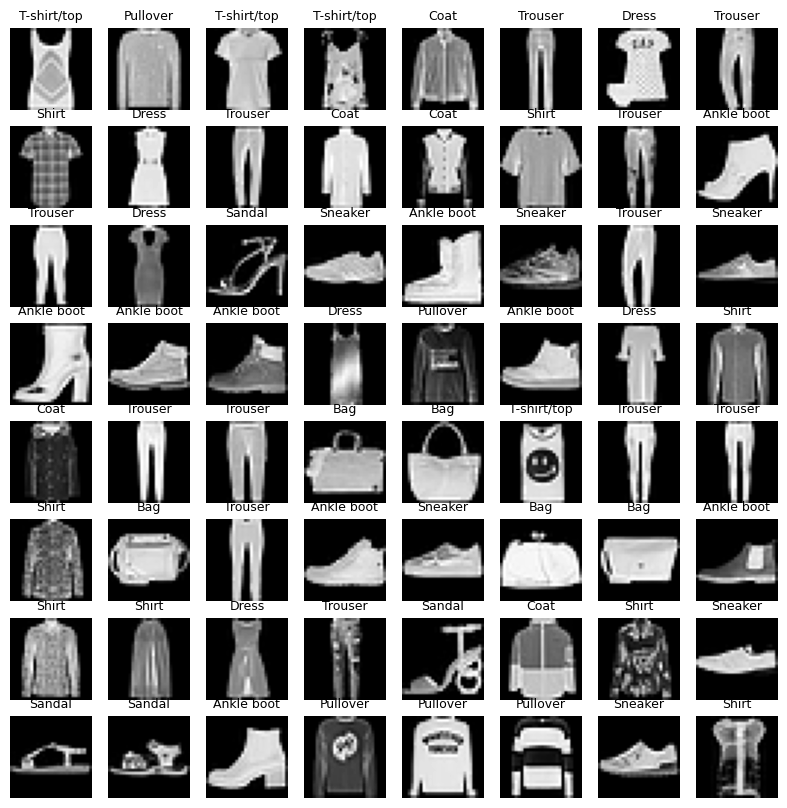

In [4]:
# 获取一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break

# 一个batch里的图片可视化
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
plt.figure(figsize=(10, 10))
for ii in np.arange(len(batch_y)):
    plt.subplot(8, 8, ii+1)
    plt.imshow(batch_x[ii, :, :], cmap=plt.cm.gray)
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.1)
plt.show()

# 测试集数据预处理
test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)  # [10000, 1, 28, 28]
test_data_y = test_data.targets  # 测试集的标签 [10000]

### LeNet

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output


### CNN

In [6]:
# 定义网络结构
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(  
                in_channels=1,    # 输入的图片 （1，28，28）
                out_channels=16,  # 经过一个卷积层之后 （16,28,28）
                kernel_size=3,    # 卷积核尺寸
                stride=1,  
        # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
                padding=1,
            ),
            nn.ReLU(),
            nn.AvgPool2d(
                        kernel_size=2,     # 平均池化层，2*2
                        stride=2,          # 池化步长2
                        ),                 # 经过池化层处理，维度为（16,14,14）
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(  
                in_channels=16,     # 输入（16,14,14）
                out_channels=32,    # 输出（32,12,12）
                kernel_size=3,
                stride=1,
                padding=0,
            ),  # 输出（32,12,12）
            nn.ReLU(),
            nn.AvgPool2d(
                kernel_size=2,      # 平均池化层，2*2
                stride=2,           # 池化步长2
            ),                      # 输出（32,6,6）
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 6 * 6, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    #  定义网络向前传播路径
    def forward(self, x):
        x = self.conv1(x)            # （batch_size,16,14,14）
        x = self.conv2(x)            # （batch_size,32,6,6）
        x = x.view(x.size(0), -1)    #  (batch_size,32*6*6)
        output = self.classifier(x)  #  (batch_size,10)
        return output
myconvnet = MyConvNet()

In [7]:
# 定义网络训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs):
    
    batch_num = len(traindataloader)                   # 获取训练总batch数
    train_batch_num = round(batch_num * train_rate)    # 按照train_rate比例进行训练集的划分
    
    # 复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    
    # 训练轮次循环
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
 
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
 
        # 每个epoch有两个训练阶段
        for step, (b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:         # 训练集
                model.train()                  # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)  # 计算损失函数
                optimizer.zero_grad()          # 清空上一层梯度
                loss.backward()                # 反向传播
                optimizer.step()               # 更新优化器的学习率
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval()                   # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
 
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
 
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], 
train_acc_all[-1]))
 
        print('{} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
 
        # 当精度创新高，复制模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(time_use // 60, time_use % 60))
 
        # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch": range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all,
              "train_acc_all": train_acc_all,
              "val_acc_all": val_acc_all,
              }
    )
    return model, train_process

In [8]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # 损失函数
myconvnet, train_process = train_model(myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25)
 
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)

Epoch 0/24
0 Train Loss: 0.4920 Train Acc: 0.8171
0 Val Loss: 0.3679 Val Acc: 0.8666
Train and val complete in 0m 42s
Epoch 1/24
1 Train Loss: 0.3252 Train Acc: 0.8813
1 Val Loss: 0.3247 Val Acc: 0.8894
Train and val complete in 1m 27s
Epoch 2/24
2 Train Loss: 0.2869 Train Acc: 0.8945
2 Val Loss: 0.3568 Val Acc: 0.8889
Train and val complete in 2m 15s
Epoch 3/24
3 Train Loss: 0.2664 Train Acc: 0.9016
3 Val Loss: 0.3393 Val Acc: 0.8842
Train and val complete in 3m 11s
Epoch 4/24
4 Train Loss: 0.2553 Train Acc: 0.9050
4 Val Loss: 0.3356 Val Acc: 0.8908
Train and val complete in 4m 5s
Epoch 5/24
5 Train Loss: 0.2429 Train Acc: 0.9091
5 Val Loss: 0.3037 Val Acc: 0.9018
Train and val complete in 4m 54s
Epoch 6/24
6 Train Loss: 0.2296 Train Acc: 0.9148
6 Val Loss: 0.3577 Val Acc: 0.8714
Train and val complete in 5m 44s
Epoch 7/24
7 Train Loss: 0.2190 Train Acc: 0.9161
7 Val Loss: 0.3062 Val Acc: 0.9001
Train and val complete in 6m 38s
Epoch 8/24
8 Train Loss: 0.2138 Train Acc: 0.9186
8 Val L

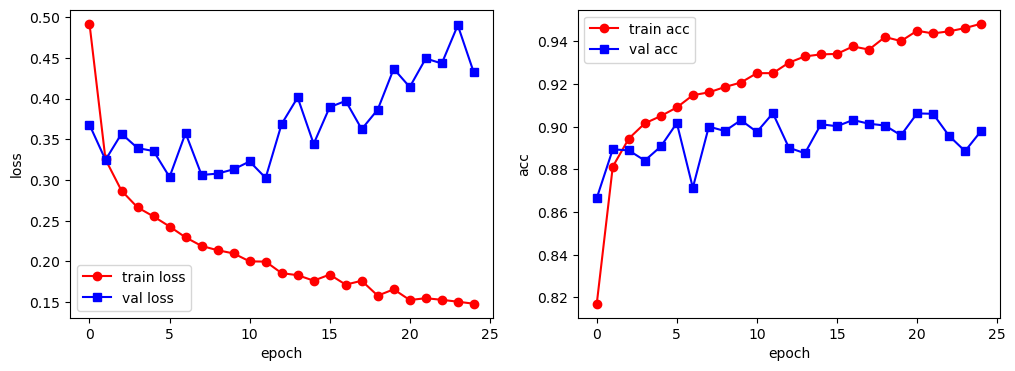

Text(120.72222222222221, 0.5, 'Predicted label')

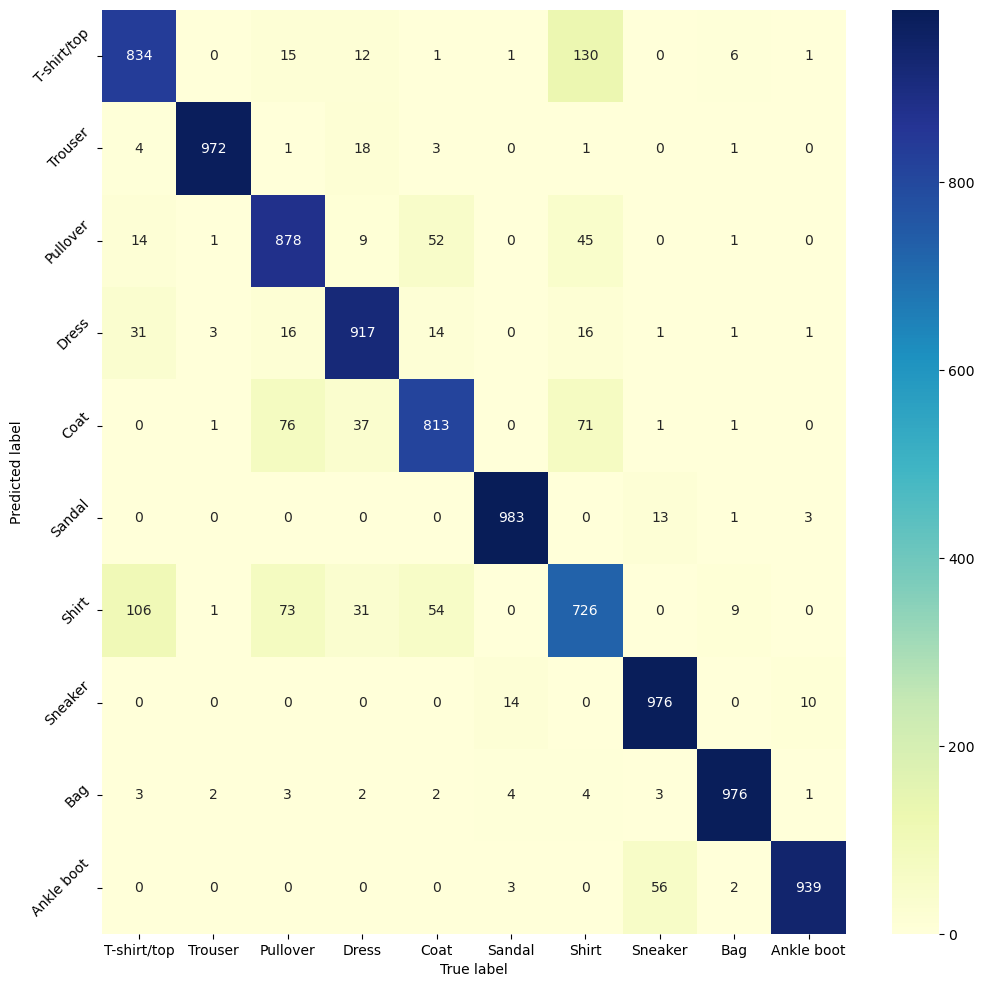

In [9]:

# 训练结果可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
 
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()
 
# 计算混淆矩阵可视化
con_mat = confusion_matrix(test_data_y, pre_lab)
con_mat_df = pd.DataFrame(con_mat, index=class_label, columns=class_label)
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(con_mat_df, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.set_ticklabels(class_label), rotation=0, ha='right')
heatmap.yaxis.set_ticklabels(heatmap.xaxis.set_ticklabels(class_label), rotation=45, ha='right')
plt.xlabel("True label")
plt.ylabel("Predicted label")